<a href="https://colab.research.google.com/github/annahunn20/Infosys_springboard-6.0-assignments/blob/main/plantdisease(MCC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import os
import zipfile
from sklearn.model_selection import train_test_split

In [7]:
# 1. Upload and Extract ZIP File
print("Upload your PlantVillage dataset ZIP file (< 500 MB recommended):")
uploaded = files.upload()
zip_path = list(uploaded.keys())[0]

Upload your PlantVillage dataset ZIP file (< 500 MB recommended):


Saving plant_disease.zip to plant_disease.zip


In [8]:
# Extract the ZIP file
extract_dir = '/content/plantvillage'
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Dataset extracted to {extract_dir}")

Dataset extracted to /content/plantvillage


In [9]:
# 2. Load dataset
image_size = (128, 128)
batch_size = 16
dataset = keras.preprocessing.image_dataset_from_directory(
    extract_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

Found 4661 files belonging to 10 classes.


In [10]:
# 3. Split into Train and Test (80-20 split)
def dataset_to_numpy(dataset):
    images, labels = [], []
    for img, lbl in dataset.unbatch():
        images.append(img.numpy())
        labels.append(lbl.numpy())
    return np.array(images), np.array(labels)

images, labels = dataset_to_numpy(dataset)
x_train, x_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

In [11]:
# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

In [12]:
# Verify shapes
print(f"Training data: {x_train.shape}, Labels: {y_train.shape}")
print(f"Test data: {x_test.shape}, Labels: {y_test.shape}")

Training data: (3728, 128, 128, 3), Labels: (3728, 10)
Test data: (933, 128, 128, 3), Labels: (933, 10)


In [13]:
# Get class names
class_names = dataset.class_names
print(f"Classes: {class_names}")

Classes: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_healthy', 'pepper_bell_bacterial_spot', 'pepper_bell_healthy', 'potato_early_blight', 'potato_healthy', 'potato_late_blight']


In [14]:
# 4. Build CNN Model
model = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

In [15]:
# 5. Compile
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
# 6. Train
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    verbose=1
)

Epoch 1/5
233/233 ━━━━━━━━━━━━━━━━━━━━ 60s 251ms/step - accuracy: 0.4049 - loss: 1.7416 - val_accuracy: 0.6785 - val_loss: 0.9715
Epoch 2/5
233/233 ━━━━━━━━━━━━━━━━━━━━ 74s 216ms/step - accuracy: 0.7920 - loss: 0.6257 - val_accuracy: 0.8114 - val_loss: 0.6021
Epoch 3/5
233/233 ━━━━━━━━━━━━━━━━━━━━ 48s 205ms/step - accuracy: 0.8914 - loss: 0.3422 - val_accuracy: 0.8103 - val_loss: 0.5376
Epoch 4/5
233/233 ━━━━━━━━━━━━━━━━━━━━ 82s 207ms/step - accuracy: 0.9401 - loss: 0.2005 - val_accuracy: 0.8039 - val_loss: 0.6610
Epoch 5/5
233/233 ━━━━━━━━━━━━━━━━━━━━ 81s 205ms/step - accuracy: 0.9641 - loss: 0.1209 - val_accuracy: 0.8210 - val_loss: 0.5642


In [17]:
# 7. Evaluate
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.8210


In [18]:
# Save model
model.save('model.h5')
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# 8. Predict on new image
from PIL import Image
import io

def preprocess_image(image):
    img = Image.open(io.BytesIO(image)).convert('RGB')
    img = img.resize(image_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


Upload a plant image to predict its disease:


Saving 0a334ae6-bea3-4453-b200-85e082794d56___GH_HL Leaf 310.1.JPG to 0a334ae6-bea3-4453-b200-85e082794d56___GH_HL Leaf 310.1.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


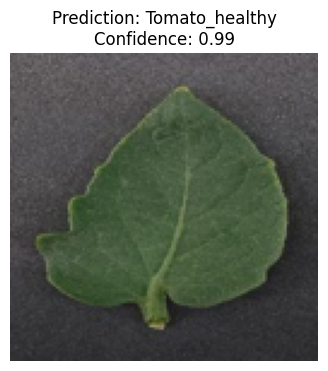

In [22]:
print("\nUpload a plant image to predict its disease:")
uploaded = files.upload()
for fn in uploaded.keys():
    img_array = preprocess_image(uploaded[fn])
    pred_probs = model.predict(img_array)[0]
    pred_class_idx = np.argmax(pred_probs)
    pred_class = class_names[pred_class_idx]
    pred_conf = pred_probs[pred_class_idx]

    plt.figure(figsize=(4,4))
    plt.imshow(img_array.squeeze())
    plt.axis('off')
    plt.title(f"Prediction: {pred_class}\nConfidence: {pred_conf:.2f}")
    plt.show()